# Practice: Train a Neural Network on Make Blobs

In this notebook, you'll train a neural network on the **make_blobs** dataset!

**What is make_blobs?** It generates Gaussian clusters - two blob-shaped clusters. This is a simpler dataset where even a linear boundary can separate the classes.

---

## How This Notebook Works

- **Instructions** explain what to do
- **TODO** sections are for you to fill in
- **Hints** are available if you get stuck
- **Solutions** are hidden - try first before looking!

---

## Step 1: Setup - Imports

First, let's import the libraries we need.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

%matplotlib inline

print("Imports successful!")

Imports successful!


## Step 2: Copy Your Value Class

Copy the `Value` class from your summary notebook (003-summary_brief_of_micrograd.ipynb).

This is the foundation - we need it for automatic differentiation!

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
		
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out
	
	def __pow__(self, exponent):
		assert isinstance(exponent, (int, float)), "Only supporting int/float powers for now"
		out = Value(self.data ** exponent, (self,), f'**{exponent}')
		def _backward():
			self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
		out._backward = _backward
		return out
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __truediv__(self, other):
		return self * other**-1
	
	def __radd__(self, other):
		return self + other
	
	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other

	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

## Step 3: Copy Your Neural Network Classes

Copy the `Neuron`, `Layer`, and `MLP` classes from your summary notebook.

In [3]:
class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]
		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

## Step 4: Generate the Make Blobs Dataset

Now let's create our training data!

**`make_blobs`** creates Gaussian clusters.

Parameters:
- `n_samples`: How many points to generate
- `centers`: Number of clusters
- `cluster_std`: Standard deviation of each cluster (spread)
- `random_state`: For reproducibility

Returns:
- `X`: The 2D coordinates of each point
- `y`: The class label (0 or 1) for each point

**Important**: Blobs have large feature values (range ~-10 to 10). Since our tanh activation saturates beyond ~2, we **must normalize** the data so gradients don't vanish!

In [4]:
X, y = make_blobs(n_samples=100, centers=2, cluster_std=1.5, random_state=42)

# IMPORTANT: Normalize the data!
# make_blobs generates features with large magnitudes (~-10 to 10)
# tanh saturates beyond ~2, so without normalization all gradients = 0
X = (X - X.mean(axis=0)) / X.std(axis=0)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Feature range after normalization: [{X.min():.2f}, {X.max():.2f}]")
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (100, 2)
y shape: (100,)
Feature range after normalization: [-1.88, 1.74]
First 5 points:
[[-1.05454573  0.88747189]
 [ 1.37251905 -0.55525261]
 [-1.07955494  1.01133093]
 [ 1.27242193 -0.2032009 ]
 [ 1.04437669 -0.44945192]]
First 5 labels: [0 1 0 1 1]


## Step 5: Convert Labels to -1 and +1

The labels from `make_blobs` are 0 and 1, but our network outputs values between -1 and +1 (because of tanh).

**Hint**: `y * 2 - 1` transforms 0 -> -1 and 1 -> +1

In [5]:
y = y * 2 - 1
print(f"Unique labels: {np.unique(y)}")

Unique labels: [-1  1]


## Step 6: Visualize the Data

Let's see what our data looks like!

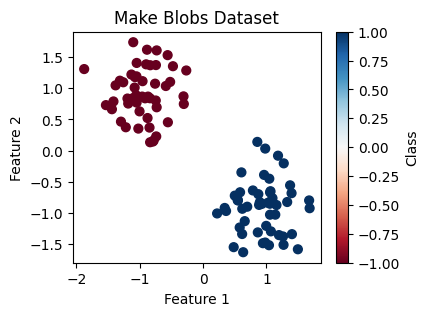

In [6]:
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Make Blobs Dataset')
plt.colorbar(label='Class')
plt.show()

## Step 7: Create the Neural Network

**Why `MLP(2, [8, 1])` for blobs?**

Look at your scatter plot above — the two blobs can be separated by a **single straight line**! This is called "linearly separable" data.

**Why this is the simplest case:**
- A single neuron computes: `tanh(w1*x + w2*y + b)`. The equation `w1*x + w2*y + b = 0` is literally a straight line in 2D!
- So even `MLP(2, [1])` (just one neuron!) could theoretically solve this
- We use `[8, 1]` (8 neurons in one hidden layer) as a small safety margin — if the line isn't perfectly straight, 8 neurons can handle slight curves

**Why NOT `[16, 16, 1]` like circles?**
- That's 337 parameters for a problem that needs ~3 (two weights + one bias for a line)
- With 100 data points and 337 parameters, the network has more knobs than data — it would **memorize** the exact training points instead of learning the general pattern (overfitting)
- Simpler data → simpler network. Always use the **smallest network that can solve your problem**

**The architecture complexity ladder:**
```
Blobs:    [8, 1]         →  25 params   →  learns a line
Circles:  [16, 16, 1]    →  337 params  →  learns a circle  
Spirals:  [16, 16, 16, 1] → 609 params  →  learns a spiral
```
More complex boundary shape = more layers and neurons needed!

In [7]:
random.seed(17)
model = MLP(2, [8, 1])

print(f"Model created!")
print(f"Total parameters: {len(model.parameters())}")

Model created!
Total parameters: 33


## Step 8: Define the Loss Function

**Why hinge loss for blobs?**

We use **hinge loss**: `max(0, 1 - y * prediction)`

Hinge loss is actually **perfect** for linearly separable data like blobs. Here's why:

1. **It's the SVM loss!** Support Vector Machines (SVMs) use exactly this loss function. SVMs are famous for finding the **best possible line** between two classes — the one with the maximum margin (distance) between the line and the nearest points of each class.

2. **Margin maximization**: Hinge loss doesn't just want correct predictions — it wants predictions with **confidence ≥ 1**. For blobs, this means:
   - The dividing line won't just barely separate the clusters
   - It'll sit right in the **middle** of the gap between them (maximum margin)
   - This gives the best generalization to new unseen points

3. **Sparse gradients help speed**: Once a blob point is classified correctly with enough margin, its loss is exactly 0. With two well-separated blobs, most points quickly reach zero loss, so only the few "hardest" boundary points keep getting trained on.

**Why L2 regularization?**
- Even for simple problems, regularization prevents weights from exploding
- With `alpha=1e-4`, it's very gentle — just enough to keep things stable
- Think of it as: "find the simplest line that separates the blobs" rather than "find any line at all"

**Why not MSE here?** Hinge loss converges faster for classification because it stops updating correctly-classified points. MSE would keep adjusting even when predictions are already correct, wasting computation.

In [8]:
def compute_loss(model, X, y, alpha=1e-4):
	# forward pass
	inputs = [list(row) for row in X]
	prediction = [model(x) for x in inputs]

	# calculate loss - Hinge loss
	losses = []
	for yi,pred in zip(y,prediction):
		margin = 1 + (-yi) * pred
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	avg_data_loss = sum(losses) * (1.0 / len(losses))
	reg_loss = alpha * sum(p*p for p in model.parameters())

	total_loss = avg_data_loss + reg_loss

	accuracy = sum(1 for yi, pred in zip(y, prediction) if (yi > 0) == (pred.data > 0)) / len(y)

	return total_loss, accuracy

## Step 9: The Training Loop!

**Why these hyperparameters?**

**`learning_rate = 1.0`** — Same reasoning as circles, but blobs converge even faster because:
- The gradient direction is very consistent (both blobs clearly pull in opposite directions)
- There's less "confusion" at the boundary compared to interleaved shapes like moons or circles
- The loss landscape for linearly separable data is smooth and convex-like — big steps work fine

**`num_iteration = 50`** — Blobs are so easy that:
- By ~10 iterations, the network usually finds the approximate dividing line
- By ~30, accuracy is often near 100%
- By ~50, it's fully converged — more iterations do nothing
- We print every 5 steps so you can watch the rapid convergence

**`n_samples = 100` + normalization** — Two important points:
- 100 samples is plenty for defining two clusters (50 per class)
- **Normalization is critical here!** `make_blobs` generates features with magnitudes ~-10 to 10. Our tanh activation gives near-zero gradient for inputs beyond ~2 (it "saturates" — the curve goes flat). Without normalization, every neuron would be stuck at output ≈ +1 or -1 with gradients ≈ 0, and the network would never learn. After normalization, features are in the range ~[-2, 2], where tanh has healthy gradients.

In [9]:
learning_rate = 1.0
num_iteration = 50

print("Training...")
print("="*50)

for iteration in range(num_iteration):
    
    loss, accuracy = compute_loss(model, X, y)
    
    for p in model.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if iteration % 5 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")
        

print("="*50)
print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

Training...
Iteration   0 | Loss: 1.3417 | Accuracy: 8.0%
Iteration   5 | Loss: 0.0115 | Accuracy: 100.0%
Iteration  10 | Loss: 0.0081 | Accuracy: 100.0%
Iteration  15 | Loss: 0.0065 | Accuracy: 100.0%
Iteration  20 | Loss: 0.0055 | Accuracy: 100.0%
Iteration  25 | Loss: 0.0049 | Accuracy: 100.0%
Iteration  30 | Loss: 0.0044 | Accuracy: 100.0%
Iteration  35 | Loss: 0.0041 | Accuracy: 100.0%
Iteration  40 | Loss: 0.0039 | Accuracy: 100.0%
Iteration  45 | Loss: 0.0036 | Accuracy: 100.0%
Final - Loss: 0.0035 | Accuracy: 100.0%


## Step 10: Visualize the Decision Boundary!

This is the coolest part - let's see what the network learned!

We'll:
1. Create a grid of points covering the plot area
2. Get the network's prediction for each point
3. Color the background based on predictions
4. Overlay the original data points

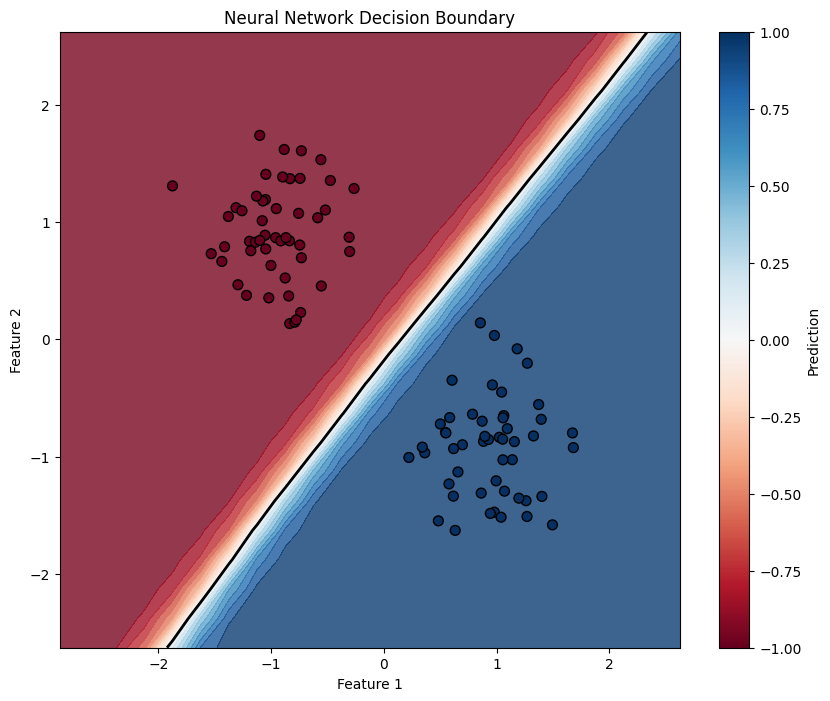

In [10]:
def plot_decision_boundary(model, X, y):
	h = 0.25
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
						 np.arange(y_min, y_max, h))
	
	mesh_points = np.c_[xx.ravel(), yy.ravel()]
	Z = []
	for point in mesh_points:
		pred = model(list(point))
		Z.append(pred.data)
	Z = np.array(Z).reshape(xx.shape)
	
	plt.figure(figsize=(10, 8))
	plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 20), cmap='RdBu', alpha=0.8)
	plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='black', s=50)
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('Neural Network Decision Boundary')
	plt.colorbar(label='Prediction')
	plt.show()

plot_decision_boundary(model, X, y)

---

## Congratulations!

You've just trained a neural network to classify the make_blobs dataset!

**What you accomplished:**
- Used the make_blobs dataset from scikit-learn
- Built an MLP classifier from scratch
- Trained the network with gradient descent
- Visualized the learned decision boundary on Gaussian clusters

---